# Detectron2 Person Removal

This notebook show the necesasary step to implement the person removal script using Facebook's detectron2 with a custom video.

# Install detectron2

In [0]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 57.0MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 8.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d5ffb5cd1d4178b4699b272a8b0d0f9ccd06e91afbc51b0de8d75b113cb677e9
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4lg_rcuw
  Running command git 

In [0]:
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 3133 (delta 15), reused 25 (delta 11), pack-reused 3075
Receiving objects: 100% (3133/3133), 2.11 MiB | 4.07 MiB/s, done.
Resolving deltas: 100% (2108/2108), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200224-cp36-none-any.whl size=35867 sha256=205283c601cd015d9547c9c386bd783a8551ecdcecd970447f3b3b9f20d96e27
  Stored in directory: /root/.cache/pip/wheels/b8/2e/65/a7a2607f82833fd1774448d1b136d80f3f72bbfd0dda6a7e66
Successfully built fvcore
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
import detectron2

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # load a model from COCO model ZOO
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the pre-trained Detectron2 model from COCO model ZOO

Load Google Drive to use a custom video:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on frames.

In [0]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x.yaml")

predictor = DefaultPredictor(cfg)

# The implementation

The next step is similat to the previous version of the person removal, however some additional things were added in order to speed up the process (for example scaling of the frames)

1920.0
1080.0
Resizing to:  (1920, 1080)


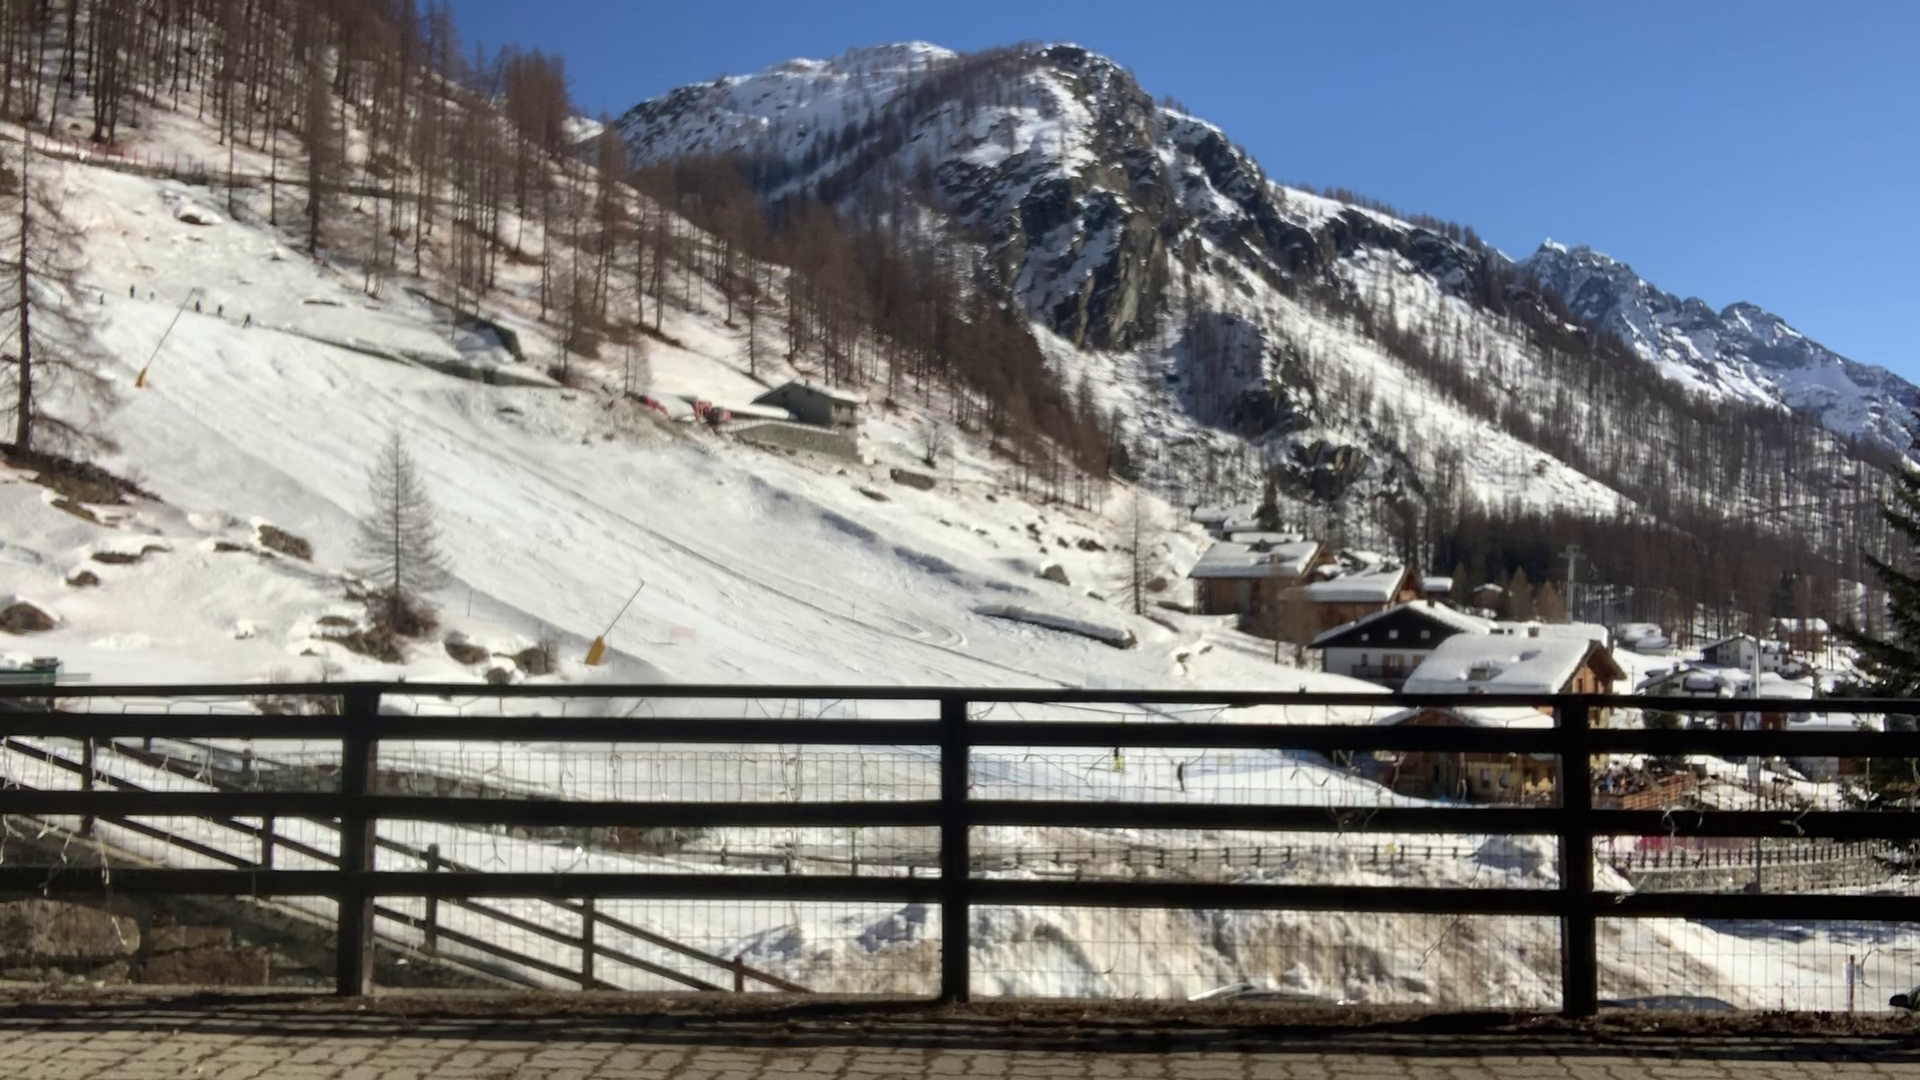

In [12]:
import cv2
import time
from scipy import ndimage

# open video stream
cap = cv2.VideoCapture('/content/drive/My Drive/person-removal/video.MOV') # change as appropriate

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

current_frame = 0

# rescale for better performances
WIDTH = cap.get(3)
print(WIDTH)
HEIGHT = cap.get(4)
print(HEIGHT)
FPS = cap.get(5)
SCALE_RATIO = 59 # percent from original size

SCALED_WIDTH = int(WIDTH * SCALE_RATIO / 100)
SCALED_HEIGHT = int(HEIGHT * SCALE_RATIO / 100)

DIM = (SCALED_WIDTH, SCALED_HEIGHT)
DIM = (1920, 1080)
print("Resizing to: ", DIM)

#cv2.startWindowThread()

# writing the output to a video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, DIM)

n_frame = 0

# first frame is too dark, taking the 19th frame as anchor point
while True:
    _, frame = cap.read()
    n_frame += 1

    if n_frame == 20:
        frame = cv2.rotate(frame, cv2.ROTATE_180)
        frame = cv2.resize(frame, DIM)
        first_frame = frame
        break

cv2_imshow(first_frame)

In [15]:
while True:
    
    print("Processing frame %s of %s" %(current_frame, total_frames), flush=True)
    
    # Capture frame-by-frame
    _, frame = cap.read()

    # resizing for faster detection
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame = cv2.resize(frame, DIM)
    

    # using a greyscale picture, also for faster detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # detect people in the image
    
    # returns the bounding boxes for the detected objects
    outputs = predictor(frame)
    outputs = outputs["instances"].pred_boxes.to('cpu').tensor.numpy().astype(int)

    # iterate over each detected person and
    # substitute the area with the first frame
    original = frame.copy()
    rectangle = frame.copy()
    
    for (x, y, w, h) in outputs:

        crop_img = first_frame[y:y + h, x:x + w]
        frame[y:y + h, x:x + w] = crop_img
        
        # could also write
        # frame[y:y + h, x:x + w] = first_frame[y:y + h, x:x + w]

        # for debugging show bounding rectangle
        cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(rectangle, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    #cv2_imshow(frame)
    out.write(frame)
    
    # also for debugging
    #cv2_imshow(frame)
    # cv2_imshow('First Frame', first_frame)
    # cv2_imshow('CLean Frame', original)
    # cv2_imshow('Rectangle Frame', rectangle)
    print('Writing to frame')
    
    
    current_frame += 1
    
    del(frame, gray, outputs, original, rectangle) # empty memory
    
    if current_frame == total_frames:
        break

# and release the output
out.release()

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Streaming output truncated to the last 5000 lines.
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 6183 of 6203
Processing frame 61


KeyboardInterrupt



# Copying the final video to Drive

In [0]:
%mv output.avi ./drive/My\ Drive/person-removal/